In [1]:
import yaml
import json
import pandas as pd
from utils import prepare_input
from main_model import two_stage_model

import matplotlib.pyplot as plt

%matplotlib inline

### Reading solved models data

In [ ]:
path = "/home1/07346/ashukla/Norta/TwoStageModel/output/sm_16/"
with open(path + "model_params.json") as file:
    model_params = json.load(file)

In [ ]:
model_params["path_to_input"] = "16_Scenario/"
model_params["path_to_output"] = "Error_Path"
model_params["mit_coarse"] = 1

In [ ]:
model_params["input1"], model_params["input2"] = prepare_input(model_params["path_to_input"])

In [ ]:
base_model = two_stage_model(model_params)        
base_model.model.update()

budget_vector = [0,10,20,30,40,50,60,70,80]

In [ ]:
hardening_decisions = {}
for budget in budget_vector:
    hardening = []
    sol_path = path + str(budget) + "M_solution.sol"
    base_model.model.read(sol_path)
    base_model.model.update()
    for sub_id in base_model.unique_substations:
        temp = round(base_model.model.getVarByName('x[' +  str(sub_id) + ']').Start)
        hardening.append(temp)
    hardening_decisions[budget] = hardening
df = pd.DataFrame(hardening_decisions)
df.index = base_model.unique_substations

df = df[df.sum(axis=1) > 0]

### Reading norta scenarios and building model from that

In [ ]:
n_scenario = 16
objective_value = {}
budget_vector = [0,10,20,30,40,50,60,70,80]
#budget_vector = [10]

for scenario_id in range(50):
    objective_value[scenario_id] = {}
    
    dir_name = 'norta_sm_' + str(n_scenario) + "_" + str(scenario_id) +'/'
    with open(r'config.yaml') as file:
        model_params = yaml.load(file, Loader=yaml.FullLoader)

    model_params["path_to_input"] = "16_Scenario/"
    model_params["path_to_output"] = "Error_Path"
    
    model_params["mip_gap"] = 0
    
    model_params["input1"], model_params["input2"] = prepare_input(model_params["path_to_input"])

    for column_id in model_params["input1"].columns:
        if "max_flood_level" in column_id:
            model_params["input1"][column_id] = 0

    norta_scenario = pd.read_csv("../scenarios/" + str(scenario_id) + "/" + "Final_Input1.csv", index_col="Unnamed: 0")
    set_of_flooded_substations = norta_scenario.columns
    meow_maps = list(norta_scenario.index)

    for row_id in range(model_params["input1"].shape[0]):
        substation_ = model_params["input1"].iloc[row_id,2]
        if str(substation_) in set_of_flooded_substations:
            busnum = model_params["input1"].index[row_id]
            model_params["input1"].loc[busnum,meow_maps] = list(norta_scenario[str(substation_)])

    base_model = two_stage_model(model_params)
    
    
    for budget in budget_vector:
        print(scenario_id, budget)
        base_model.budget_ref.rhs = budget*1e6    
        temp_constraint =  base_model.model.addConstrs((base_model.x[substation] == df.loc[substation, budget]) 
                                                   for substation in list(df.index))
                    
        base_model.model.setParam("LogFile", model_params["path_to_output"] + str(budget) + "M")
        base_model.model.setParam("MIPGap", model_params["mip_gap"])
        base_model.model.setParam("TimeLimit", model_params["time_limit"])
        base_model.model.setParam("Method", model_params["solver_method"])
        base_model.model.optimize()
        objective_value[scenario_id][budget] = base_model.model.ObjVal/10
        base_model.model.remove(temp_constraint)
        print("\n\n\n\n")

In [ ]:
objective_value = pd.DataFrame(objective_value)
objective_value.to_csv("norta_out_of_sample_testing.csv")

In [ ]:
objective_value = pd.read_csv("norta_out_of_sample_testing.csv", index_col="Unnamed: 0")
print(objective_value.T.describe().round(3).to_latex())

# Analysis of marginal distribution

In [2]:
temp_list = []

for scenario_id in range(50):
    norta_scenario = pd.read_csv("../scenarios/" + str(scenario_id) + "/" + "Final_Input1.csv", index_col="Unnamed: 0")
    temp_list.append(norta_scenario)
    
result = pd.concat(temp_list, axis=0)

# Resetting index if needed
result.reset_index(drop=True, inplace=True)

In [3]:
meow_map = pd.read_csv("/home1/07346/ashukla/Norta/TwoStageModel/16_Scenario/Final_Input1.csv")
meow_map = meow_map.drop(['BusNum', 'BusName', 'SubName', 'Latitude', 'Longitude',
       'generation_capacity_min', 'generation_capacity_max', 'load'], axis=1).drop_duplicates()

meow_map = meow_map[meow_map.iloc[:,1:].sum(axis=1) > 0]
meow_map = meow_map.set_index("SubNum")
meow_map = meow_map.T

meow_map = meow_map.reset_index(drop=True)

# Computing wasserstein distance

In [4]:
result

,241,247,274,286,287,288,297,299,301,311,...,1110,1111,1129,1130,1132,1133,1136,1141,1143,1145
0,5,11,18,2,1,14,9,10,11,7,...,0,17,0,0,19,10,11,0,5,19
1,0,6,13,0,0,10,6,5,8,2,...,0,14,0,5,17,8,8,4,4,18
2,1,8,16,0,0,11,7,7,9,5,...,0,17,0,5,19,10,11,4,4,20
3,5,11,17,3,1,13,9,10,11,7,...,0,14,0,0,15,8,7,0,0,16
4,5,7,15,3,1,10,8,7,11,4,...,0,13,0,0,15,6,7,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,4,13,0,0,7,5,4,8,0,...,2,18,0,7,21,10,13,7,4,21
796,0,5,15,0,0,8,9,5,11,0,...,1,17,0,0,20,8,13,5,0,20
797,0,8,17,0,0,11,9,7,11,2,...,0,16,0,2,19,10,11,4,0,20
798,0,1,10,0,0,4,4,1,8,0,...,4,16,0,5,20,9,13,7,0,21


In [5]:
from scipy.stats import wasserstein_distance

lister = []
for i in meow_map.columns:
    # Assuming series1 and series2 are your pandas Series
    emd_distance = wasserstein_distance(result[str(i)], meow_map[i])
    print("Earth Mover's Distance:", i, round(emd_distance,3))
    lister.append(round(emd_distance,3))

Earth Mover's Distance: 241 0.047
Earth Mover's Distance: 247 0.057
Earth Mover's Distance: 274 0.101
Earth Mover's Distance: 286 0.004
Earth Mover's Distance: 287 0.019
Earth Mover's Distance: 288 0.057
Earth Mover's Distance: 297 0.056
Earth Mover's Distance: 299 0.09
Earth Mover's Distance: 301 0.054
Earth Mover's Distance: 311 0.066
Earth Mover's Distance: 314 0.001
Earth Mover's Distance: 327 0.065
Earth Mover's Distance: 329 0.08
Earth Mover's Distance: 332 0.078
Earth Mover's Distance: 334 0.125
Earth Mover's Distance: 340 0.08
Earth Mover's Distance: 343 0.052
Earth Mover's Distance: 349 0.067
Earth Mover's Distance: 350 0.001
Earth Mover's Distance: 923 0.106
Earth Mover's Distance: 929 0.011
Earth Mover's Distance: 932 0.089
Earth Mover's Distance: 948 0.06
Earth Mover's Distance: 951 0.065
Earth Mover's Distance: 952 0.072
Earth Mover's Distance: 953 0.119
Earth Mover's Distance: 954 0.08
Earth Mover's Distance: 955 0.144
Earth Mover's Distance: 956 0.085
Earth Mover's Dista

In [11]:
meow_map[1145]

0     19
1     18
2     16
3     17
4     21
5     21
6     21
7     20
8     20
9     21
10    21
11    20
12    18
13    19
14    19
15    19
Name: 1145, dtype: int64

In [12]:
result["1145"]

0      19
1      18
2      20
3      16
4      16
       ..
795    21
796    20
797    20
798    21
799    21
Name: 1145, Length: 800, dtype: int64

<AxesSubplot:>

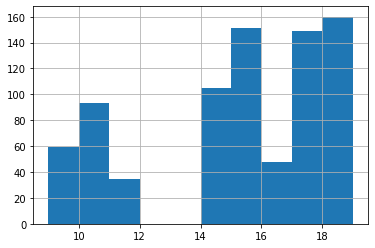

In [6]:
result["984"].hist()

<AxesSubplot:>

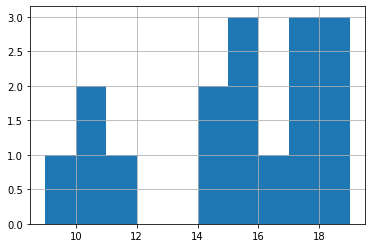

In [7]:
meow_map[984].hist()

In [8]:
pd.DataFrame(lister).describe()

,0
count,72.000000
mean,0.073222
std,0.037514
min,0.001000
25%,0.052000
50%,0.071000
75%,0.103000
max,0.146000


In [10]:
wasserstein_distance([1,0],[0,1] )

0.0

# Error Analysis

In [ ]:
t1 = meow_map.corr()
t2 = result.corr()

In [ ]:
diff = []
for i in range(t1.shape[0]):
    for j in range(t1.shape[0]):

        if (i>j):
            continue
        
        v1 = abs(t1.iloc[i,j]-t2.iloc[i,j])
        v2 = (abs(t1.iloc[i,j]))
        #value  = 100*(v1/v2)
        value = v1
        # if value > 10:
        #     print(v1, v2, value, i, j)
        
        diff.append(value)

In [ ]:
pd.DataFrame(diff).describe()